# Libraries

In [1]:
library(CommPackage)
library(ggplot2)
library(gridExtra)
library(grid)

# Paths

In [3]:
path_in <- getwd()

print("path_in")
print(path_in)

[1] "path_in"
[1] "/work/project/ladcol_011/MariaWF"


# Load data

In [4]:
# load interactions
load(paste0(path_in
            ,"/interactions.RData"))
print(str(interactions))

List of 23
 $ per_sample_anno_edges:List of 33
  ..$ AML1012-D0:'data.frame':	24408 obs. of  29 variables:
  .. ..$ edge_ID            : chr [1:24408] "HSPC:ADAM10_HSPC:AXL" "HSPC:ADAM15_HSPC:ITGA5" "HSPC:ADAM15_HSPC:ITGA9" "HSPC:ADAM15_HSPC:ITGAV" ...
  .. ..$ ligand_gene_name   : chr [1:24408] "ADAM10" "ADAM15" "ADAM15" "ADAM15" ...
  .. ..$ receptor_gene_name : chr [1:24408] "AXL" "ITGA5" "ITGA9" "ITGAV" ...
  .. ..$ sending_cell_type  : chr [1:24408] "HSPC" "HSPC" "HSPC" "HSPC" ...
  .. ..$ receiving_cell_type: chr [1:24408] "HSPC" "HSPC" "HSPC" "HSPC" ...
  .. ..$ f_s                : num [1:24408] 0.496 0.496 0.496 0.496 0.496 ...
  .. ..$ f_r                : num [1:24408] 0.496 0.496 0.496 0.496 0.496 ...
  .. ..$ f_s_max            : num [1:24408] 0.945 0.945 0.945 0.945 0.945 ...
  .. ..$ f_r_max            : num [1:24408] 0.945 0.945 0.945 0.945 0.945 ...
  .. ..$ a_s_l              : num [1:24408] 1 0.124 0.124 0.124 0.124 ...
  .. ..$ nr_s_l_active      : num [1:24408] 469

# Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_edges` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_expr_l_s_active_control`) and within the case cohort (`mean_expr_l_s_active_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_expr_r_r_active_control`) and within the case cohort (`mean_expr_r_r_active_case`).

Following parameters for the visulisation will be stored in the `anno_edges` list:
- standard deviation of a ligand in the active fraction of the sending cell type within the control cohort (`sd_expr_l_s_active_control`) and within the case cohort (`sd_expr_l_s_active_case`). 
- standard deviation of a receptor in the active fraction of the receiving cell type within the control cohort (`sd_expr_r_r_active_control`) and within the case cohort (`sd_expr_r_r_active_case`).
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_edges` list:
- log2 fold change of `edge_weights` between the cases and the controls (`log2FC_edge_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [ ]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_edges))

# QC

For the quality check, we use two filters: the **quality filter** and the **discrepancy filter**. An interaction is considered of good quality, if it passes both filters.

The **quality filter** checks the log10 cumulative weight vs. number of samples showing the interaction. To pass this filter, the interaction need to pass both the `threshold_nr_expr_samples` and the `threshold_log10meanexpr_per_condition` thresholds.

The `threshold_nr_expr_samples` threshold is applied on interactions.
It defines the minimum number of samples in which an interaction has a non-zero value.
If an interaction is non-zero in less samples, it will be filtered out. We recommend to set this threshold smaller or equal to the number of samples in the smalles cohort.

In [7]:
threshold_nr_expr_samples <-  6
print("threshold_nr_expr_samples >")
print(threshold_nr_expr_samples)

[1] "threshold_nr_expr_samples >"
[1] 6


The `threshold_log10_cum_weight` threshold is applied on interactions.
It defines the minimum log10 cumulative weight of an interaction.
If an interaction has a lower log10 cumulative weight, it will be filtered out.

In [8]:
threshold_log10_cum_weight <-  0.01
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.01


The **discrepancy filter** checks the expression level of the ligand and the receptor of an interaction for the cases and the controls separately. This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [9]:
threshold_log10meanexpr_per_condition <- 0.01
print("threshold_log10meanexpr_per_condition >")
print(threshold_log10meanexpr_per_condition)

[1] "threshold_log10meanexpr_per_condition >"
[1] 0.01


A good quality interaction should pass both filters.

The `filter_edges` function produces one plot for the **quality filter** and two plots for the **discrepancy filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_edges` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_edges` function.

In [10]:
colnames(interactions$anno_edges)

[1] "edge_ID"                                   
 [2] "ligand_gene_name"                          
 [3] "receptor_gene_name"                        
 [4] "sending_cell_type"                         
 [5] "receiving_cell_type"                       
 [6] "mean_e_s_l_control"                        
 [7] "mean_e_s_l_case"                           
 [8] "mean_e_r_r_control"                        
 [9] "mean_e_r_r_case"                           
[10] "log2FC_rho_s"                              
[11] "log2FC_rho_r"                              
[12] "log2FC_rho"                                
[13] "log2FC_phi_s_l"                            
[14] "log2FC_phi_r_r"                            
[15] "log2FC_phi"                                
[16] "log2FC_p_s_l"                              
[17] "log2FC_p_r_r"                              
[18] "log2FC_p"                                  
[19] "log2FC_weights"                            
[20] "log10_cum_weight"                          
[21] "nr_expr_samples"                           
[22] "passed_log10_cum_weight_filter"            
[23] "passed_nr_expr_samples_filter"             
[24] "passed_log10_meanexpr_control_filter"      
[25] "passed_log10_meanexpr_case_filter"         
[26] "passed_log10_meanexpr_per_condition_filter"
[27] "passed_QC_filter"                          
[28] "p.value"                                   
[29] "p.adj"                                     
[30] "passed_FDR_threshold"                      
[31] "passed_log2FC_threshold"                   
[32] "sign"

In [11]:
length(colnames(interactions$anno_edges))

[1] 32

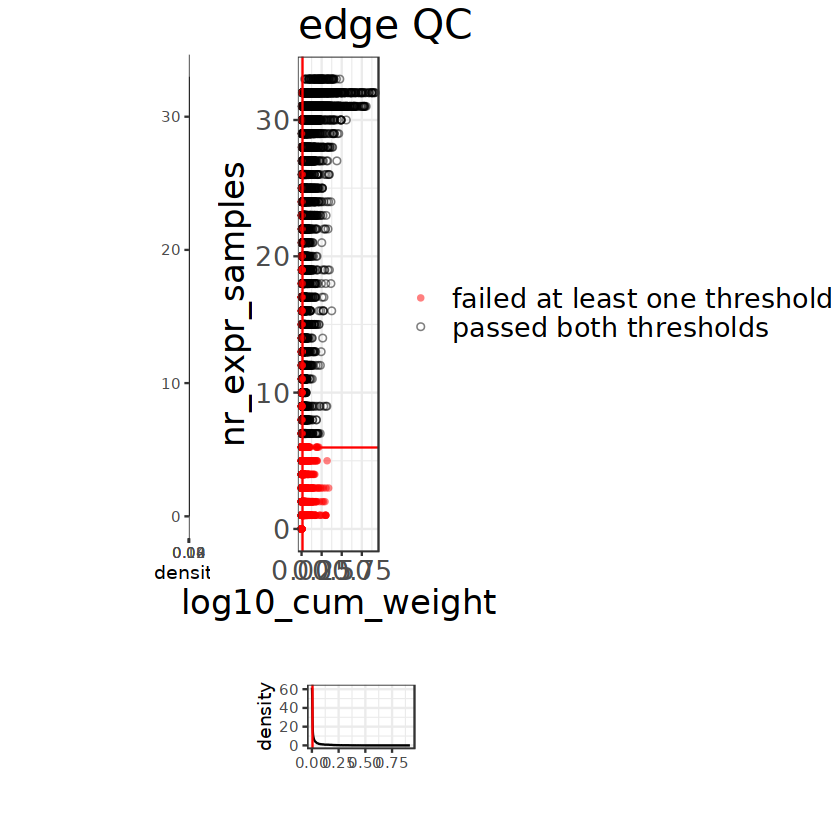

In [12]:
plot_cumW_vs_nrSamples(df = interactions$anno_edges
                               ,threshold_log10_cum_weight = threshold_log10_cum_weight
                               ,threshold_nr_expr_samples = threshold_nr_expr_samples
        )

[1] "filter weak edges"


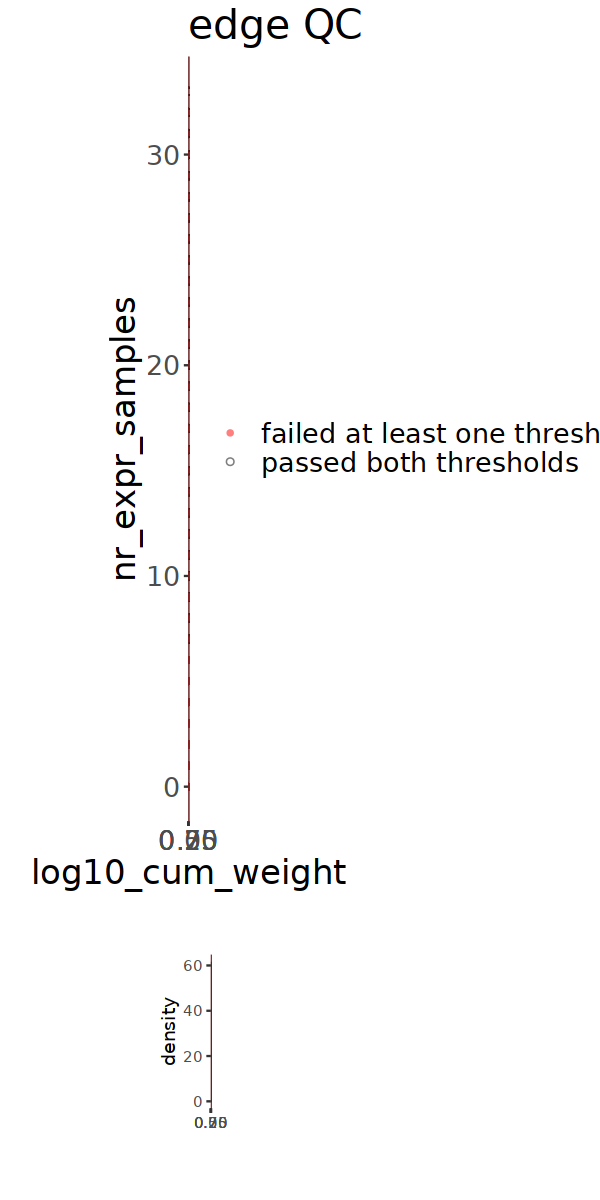

[1] "16706 out of 24408 edges do not pass the thresholds for log10 cumulative edge weight > 0.01 and number of expression samples > 6 . Also  13994  edges didn't pass the discrepancy filter.  In total, 17020  bad quality edges will be removed and 7388 good quality edges will remain."


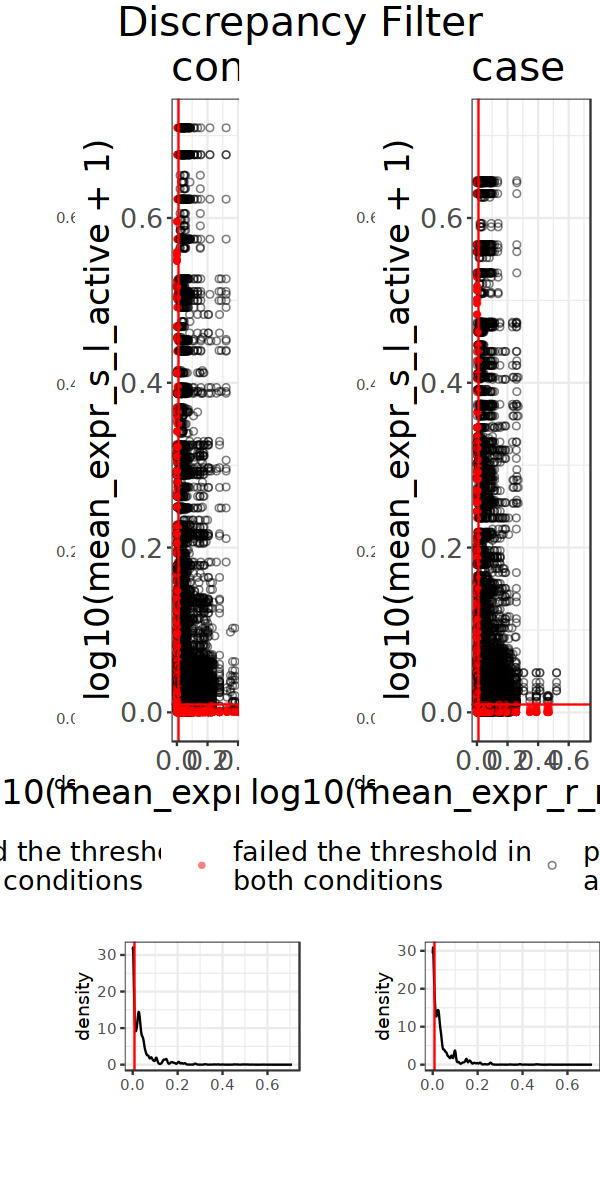

In [13]:
print("filter weak edges")

options(repr.plot.height = 10
       ,repr.plot.width = 5)
interactions <- filter_edges(x = interactions
                             ,threshold_nr_expr_samples = threshold_nr_expr_samples
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10meanexpr_per_condition
                             ,verbose = TRUE
)

In [14]:
print(str(interactions$thresholds))
print(str(interactions$anno_edges))

List of 8
 $ threshold_expr                        : num 0.05
 $ threshold_nr_active_cells             : num 0
 $ threshold_celltype_size               : num 4
 $ threshold_log10_cum_weight            : num 0.01
 $ threshold_nr_expr_samples             : num 6
 $ threshold_log10_meanexpr_per_condition: num 0.01
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	24408 obs. of  32 variables:
 $ edge_ID                                   : chr  "HSPC:ADAM10_HSPC:AXL" "HSPC:ADAM15_HSPC:ITGA5" "HSPC:ADAM15_HSPC:ITGA9" "HSPC:ADAM15_HSPC:ITGAV" ...
 $ ligand_gene_name                          : chr  "ADAM10" "ADAM15" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "AXL" "ITGA5" "ITGA9" "ITGAV" ...
 $ sending_cell_type                         : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ receiving_cell_type                       : chr  "HSPC" "HSPC" "HSPC" "HSPC" ...
 $ mean_e_s_l_control                  

We can now plot a PCA on the good quality interactions.

In [15]:
# update this function in the package!!
# PCA
plot_pca <- function(comm_result
                     ,which_edges = NULL 
                     # NULL if top and by_param are set 
                     # or "all" 
                     # or boolean vector with length of all edges
                     # e.g. "ADAM10" %in% Single_Cell_Result$anno_edges$ligand_gene_name 
                     # or "T" %in% Single_Cell_Result$anno_edges$sending_cell_type
                     #,top = NULL 
                     ,by_param 
                     # passed_QC_filter
                     # passed_FDR_threshold
                     # passed_log2FC_threshold
                     # sign
                     ,values_to_plot 
                     # edge_weights, 
                     # expr_l_s_active, 
                     # expr_r_r_active, 
                     # nr_l_s_active, 
                     # nr_r_r_active, 
                     # phi, 
                     # phi_l_s, 
                     # phi_r_r, 
                     # p, 
                     # p_l_s, 
                     # p_r_r
                     ,font_size = 8
                     ,color_case = "#7C001F" # "darkred"
                     ,color_control = "#7AC5CD" # "CadetBlue3"
                     #,xlim_max = 3
                     #,xlim_min = -3
                     #,ylim_max = xlim_max
                     #,ylim_min = xlim_min
                     ,show_legend = FALSE
){
        anno_samples <- comm_result$anno_samples
        
        #print(str(df))
        
        if(is.null(which_edges)){
                idx_edges <- comm_result$anno_edges[,by_param] & (!is.na(comm_result$anno_edges[,by_param]))
        } else if(which_edges[1] == "all"){
                idx_edges <- rep(TRUE
                                 ,nrow(df))
        } else {
                idx_edges <- which_edges
        }
        #print(str(idx_edges))
            
        df <- as.matrix(comm_result[[values_to_plot]][idx_edges,])
        
        col_samples <- sapply(comm_result$anno_samples$case_or_control ## add to object; creat column with "case" and "control"
                              ,function(i){
                                      ifelse(grepl("case"
                                                   ,i)
                                             ,color_case
                                             ,color_control
                                      )
                              })
        #print(str(col_samples))
        
        # calculate PCA
        my_pca <- prcomp(t(df)
                         #, center=TRUE
                         #, scale.=TRUE
        )
        #print(str(my_pca))
        
        # plot PCA
        
        df <- data.frame(PC1 = my_pca$x[,"PC1"]
                         ,PC2 = my_pca$x[,"PC2"]
                         ,health_status = anno_samples$health_status
                         ,sample = anno_samples$sample_ID
        )
        my_colors <- sapply(anno_samples$case_or_control
                            ,function(i) ifelse(i == "case"
                                                ,color_case
                                                ,color_control
                            )
        )
        names(my_colors) <- anno_samples$health_status
        
        lim_x <- max(abs(df$PC1))
        lim_y <- max(abs(df$PC2))
        
        
        ggplot(df
               ,aes(x = PC1
                    ,y = PC2
                    ,color = health_status
                    ,label=sample
               )
        ) +
                geom_text(aes(label=sample)
                          ,hjust=0
                          , vjust=0
                          ,size = font_size
                          ,show_guide = show_legend
                ) +
                scale_color_manual(values = my_colors) +
                #xlim(c(xlim_min
                #       ,xlim_max
                #)
                #)+
                #ylim(c(ylim_min
                #       ,ylim_max
                #)
                #)+
                theme_bw() 
        
}

In [16]:
options(repr.plot.height = 6
       ,repr.plot.width = 7)
plot_pca(comm_result = interactions
         ,by_param = "passed_QC_filter"
         ,values_to_plot = "edge_weights"
         ,font_size = 5
        )

ERROR: Error in array(x, c(length(x), 1L), if (!is.null(names(x))) list(names(x), : 'data' must be of a vector type, was 'NULL'


# Distribution check

In [ ]:
plot_distr <- function(my_df
                      ,param_name){
    
    ggplot(data = my_df
           ,aes(x = param
               )
          )+
    geom_density()+
    xlab("")+
    theme(text = element_text(size=0))+
    ggtitle(param_name)+
    theme_bw()+
    theme(plot.margin = unit(c(0, 0, 1.8, 0), "cm"))
                                    
}

In [ ]:
# all edges
rho_s <- plot_distr(my_df = data.frame(param = unlist(interactions$rho_s))
                                ,"rho_s"
                                )

rho_r=plot_distr(data.frame(param = unlist(interactions$rho_r))
                                ,"rho_r"
                                )
phi_l_s=plot_distr(data.frame(param = unlist(interactions$phi_l_s))
                                ,"phi_l_s"
                                )
phi_r_r=plot_distr(data.frame(param = unlist(interactions$phi_r_r))
                                ,"phi_r_r"
                                )
p_l_s=plot_distr(data.frame(param = unlist(interactions$p_l_s))
                                ,"p_l_s"
                                )
p_r_r=plot_distr(data.frame(param = unlist(interactions$p_r_r))
                                ,"p_r_r"
                                )
options(repr.plot.height = 15)
grid.arrange(rho_s
             ,rho_r
             ,phi_l_s
             ,phi_r_r
             ,p_l_s
             ,p_r_r
             ,nrow = 3
             ,ncol = 2
             ,top=textGrob("All edges"
                           ,gp = gpar(fontsize = 24))
        )

In [ ]:
# good quality edges
rho_s <- plot_distr(my_df = data.frame(param = unlist(interactions$rho_s[interactions$anno_edges$passed_QC_filter,]))
                                ,"rho_s"
                                )

rho_r=plot_distr(data.frame(param = unlist(interactions$rho_r[interactions$anno_edges$passed_QC_filter,]))
                                ,"rho_r"
                                )
phi_l_s=plot_distr(data.frame(param = unlist(interactions$phi_l_s[interactions$anno_edges$passed_QC_filter,]))
                                ,"phi_l_s"
                                )
phi_r_r=plot_distr(data.frame(param = unlist(interactions$phi_r_r[interactions$anno_edges$passed_QC_filter,]))
                                ,"phi_r_r"
                                )
p_l_s=plot_distr(data.frame(param = unlist(interactions$p_l_s[interactions$anno_edges$passed_QC_filter,]))
                                ,"p_l_s"
                                )
p_r_r=plot_distr(data.frame(param = unlist(interactions$p_r_r[interactions$anno_edges$passed_QC_filter,]))
                                ,"p_r_r"
                                )
options(repr.plot.height = 15)
grid.arrange(rho_s
             ,rho_r
             ,phi_l_s
             ,phi_r_r
             ,p_l_s
             ,p_r_r
             ,nrow = 3
             ,ncol = 2
             ,top=textGrob("Good quality edges"
                           ,gp = gpar(fontsize = 24))
        )

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [ ]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

In [ ]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. THe `test_diff` function stores the results as boolean vector to the `anno_edges` list of the interactions object.

In [ ]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                                ,threshold_fdr = threshold_fdr
                                ,threshold_log2FC = threshold_log2FC
                                )
print(str(interactions$thresholds))
print(str(interactions$anno_edges))

We can now visualize the interactions with a vulcano plot.

In [ ]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 8)

idx_good <- interactions$anno_edges$passed_QC_filter

df <- data.frame(log2FC = interactions$anno_edges$log2FC_edge_weights[idx_good]
                 ,y = -log10(interactions$anno_edges$p.adj[idx_good])
                 ,significant = interactions$anno_edges$sign[idx_good]
                )

xlab <- "log2 fold change"
ylab <- "-log10 p.adj"

xlim <- c(-max(abs(df$log2FC))
          ,max(abs(df$log2FC))
         )
ylim <- c(0, max(df$y))

p <- ggplot(data = df
            ,aes(x = log2FC
                 ,y = y
                 ,color = significant
                 ,size = significant
                 ,shape = significant
                ))+
geom_point()+
scale_color_manual(values = c("gray80", "black"))+
scale_size_manual(values = c(0.5, 1.5))+
xlab(xlab)+
ylab(ylab)+
xlim( xlim )+
ylim(ylim)+
theme_bw()+
theme(text = element_text(size=20))+
geom_vline(xintercept = interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_vline(xintercept = -interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_hline(yintercept = -log10(interactions$thresholds$threshold_fdr)
          ,lty = 2
          ,color = "gray")
p
